# Robust machine learning with ML Pipelines

Previously, we set the stage for machine learning: from a raw data set, we tamed the data and crafted features based on our exploration and analysis of the data. We continue our journey with ML. We delve deeper into transformers and estimators, this time in the context of an ML pipeline. With this new tool, we first train and evaluate our initial model. We then learn about customizing an ML pipeline at runtime, using cross-validation, a popular ML optimization technique, for optimizing our model parameters. Finally, we briefly discuss model interpretability by extracting the model coefficients (the weights attributed to each
parameter) from our ML pipeline.

### Transformers and estimators: The building blocks of ML in spark

We take a second look at transformers and estimators in the context of reusable and parameterizable building blocks. It is crucial that we understand not only how to create, but also how to modify those building blocks to use ML pipelines with optimal efficiency.

Transformers and estimators are very useful classes for ML modeling. When we train an ML model, we get back a fitted model, which is akin to a new program that we did not code explicitly. This new data-driven program then has one sole purpose: taking a properly formatted data set and transforming it by appending a prediction column. 

To illustrate how a transformer and an estimator are parameterized, we will use a transformer and an estimator defined and used in [previous chapter](./12_Preparing_ML_Features.ipynb):
- `continuous_assembler` — a VectorAssembler transformer that takes five columns and creates a Vector column to be used for model training
- `consinuous_scaler` — a MinMaxScaler estimator that scales values contained in a Vector column, returning values between 0 and 1 for each element in the vectors

In [5]:
%%capture
%run ./12_Preparing_ML_Features.ipynb
# Restoring the previous notebook, variables and imports

In [6]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

CONTINUOUS_NB = ["rating", "calories_i", "protein_i", "fat_i", "sodium_i"]

continuous_assembler = VectorAssembler(
    inputCols=CONTINUOUS_NB, outputCol="continuous"
)

continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

### Data comes in, data comes out: The Transformer

In our `VectorAssembler` transformer example, we provide two arguments to the constructor: `inputCols` and `outpulCol`. These arguments provide the necessary functionality to create a fully functional `VectorAssembler` transformer. This transformer’s sole purpose—through its `transform()` method—is to take the values in `inputCols` (assembled values) and return a single column, named `outputCol`, that contains a vector of all the assembled values.

The parameterization of a transformer is called _Params_ (capital P). When instantiating a transformers class, just like with any Python class, we pass the parameters we want as arguments, making sure to explicitly specify each keyword. Once the transformer has been instantiated, PySpark provides us with a set of methods to extract and modify Params. 

<img src="images/continuous_assembler.png">

##### PEEKING UNDER THE HOOD: GETTING AND EXPLAINING THE PARAMS

The instantiation of VectorAssembler accepted three arguments: `inputCols`, `outputCol`, and `handleInvalid`. We also hinted that the configuration of a transformer (and estimator, by the same occasion) class instance relied on Params, which drove the behavior of the transformers. In this section, we explore Params, highlight their similarities and differences compared to regular class attributes, and address why those differences matter. 

In [8]:
print(continuous_assembler.outputCol)
# VectorAssembler_e18a6589d2d5__outputCol

# Rather than returning the continuous
# value passed as an argument to outputCol,
# we get an object called a Param.

VectorAssembler_04f89de08434__outputCol


In [9]:
print(continuous_assembler.getOutputCol()) # => continuous

continuous


In [10]:
print(continuous_assembler.explainParam("outputCol"))
# outputCol: output column name.
# (default: VectorAssembler_e18a6589d2d5__output, current: continuous)

outputCol: output column name. (default: VectorAssembler_04f89de08434__output, current: continuous)


##### SETTING PARAMS OF AN INSTANTIATED TRANSFORMER USING GETTERS AND SETTERS

How do we change the Params of a transformer? For every getter, there is a setter, which is simply putting the word set, followed by the name of our Param in CamelCase. Unlike getters, setters take the new value as their sole argument. 



In [11]:
continuous_assembler.setOutputCol("more_continuous")

print(continuous_assembler.getOutputCol()) # => more_continuous

more_continuous


In [12]:
continuous_assembler.setParams(
    inputCols=["one", "two", "three"], handleInvalid="skip"
)

print(continuous_assembler.explainParams())

handleInvalid: How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip'). (default: error, current: skip)
inputCols: input column names. (current: ['one', 'two', 'three'])
outputCol: output column name. (default: VectorAssembler_04f89de08434__output, current: more_continuous)


Finally, if you want to return a Param to its default value, you can use the `clear()` method. This time, you need to pass the Param object. we reset the handleInvalid Param by using clear(). We pass the actual Param as an argument, accessed via the attribute slot seen at the beginning of the section, `continuous_assembler.handleInvalid`. 

In [13]:
continuous_assembler.clear(continuous_assembler.handleInvalid)

print(continuous_assembler.getHandleInvalid()) # => error

error


### Data comes in, transformer comes out: The Estimator

Where a transformer transforms an input data frame into an output data frame, an estimator is fitted on an input data frame and returns an output transformer. In this section, we see that this relationship between transformers and estimators means that they are Param-eterized the same way.

Where a transformer uses a transform() method, applied to a data frame, to return a transformed data frame, an estimator uses a fit() method, applied to a data frame, to return a fully parameterized transformer called a Model. This distinction enables estimators to configure transformers based on the input data.

As an example, the MinMaxScaler estimator 13.2 takes four parameters, two of which rely on the default value:
- min and max, which are the minimum and maximum values our scaled column will take. We keep both at their default of 0.0 and 1.0, respectively.
- inputCols and outputCols are the input and output column, respectively. They follow the same conventions as the transformer.

$$MMS(e_i) = \left(\frac{e_i - E_{min}}{E_{max} - E_{min}} \text{x} (max - min)\right)$$

<img src="images/min_max_estimator.png">

Because the transformation relies on actual values from the data, we can’t use a plain transformer, which expects to “know” everything (through its Param-eterization) before it can apply the `transform()` method. In the case of the `MinMaxScaler`, we can translate `E_min` and `E_max` as simple operations (`min()` and `max()` come from `pyspark.sql.functions`):
- E_min = min(inputCol)
- E_max = max(inputCol)

Once these values are computed (during the `fit()` method), PySpark creates, Parameterizes, and returns a transformer/model.

### BUilding a (complete) machine learning pipeline

Pipelines build on transformers and estimators to make training, evaluating, and optimizing ML models much clearer and more explicit. ML pipelines are implemented through the Pipeline class, which is a specialized version of the estimator. The Pipeline estimator has only one Param, called stages, which takes a list of transformers and estimators. 



In [14]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF

imputer = MF.Imputer(
    strategy="mean",
    inputCols=["calories", "protein", "fat", "sodium"],
    outputCols=["calories_i", "protein_i", "fat_i", "sodium_i"],
)

continuous_assembler = MF.VectorAssembler(
    inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous",
)

continuous_scaler = MF.MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

food_pipeline = Pipeline(
    stages=[imputer, continuous_assembler, continuous_scaler]
)


In practical terms, since the pipeline is an estimator, it has a `fit()` method that generates a `PipelineModel`. Under the hood, the pipeline applies each stage in order, calling the appropriate method depending on if the stage is a transformer (`transform()`) or an estimator (`fit()`). By wrapping all of our individual stages into a pipeline, we only have one method to call, `fit()`, knowing that PySpark will do the right thing to yield a `PipelineModel`.

<img src="images/ml_pipeline.png">

When using pipelines, remember that the data frame will travel each stage. For instance, the `continuous_scaler` stage will have the output of the data frame transformed by `continuous_scaler`. For estimator stages, the data frame stays identical, as `fit()` does not transform the data frame but returns a Model instead.

#### Assembling the final data set with the vector column type

We already know how to assemble data into a vector: use the `VectorAssembler`. Nothing is new here; we can create a `VectorAssembler` stage to assemble all the columns we want to be provided to our ML training. We assemble all of our `BINARY_COLUMNS`, the `_ratio` columns we created in [previous chapter](./12_Preparing_ML_Features.ipynb), and the `continuous_scaled` vector column from our pipeline. PySpark will do the right thing when assembling vector columns in another vector: rather than getting nested vectors, the assembly step will flatten everything into a single, ready-to-use vector.

In [15]:
preml_assembler = MF.VectorAssembler(
    inputCols=BINARY_COLUMNS
    + ["continuous_scaled"]
    + ["protein_ratio", "fat_ratio"],
    outputCol="features",
)

food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)

food_pipeline_model = food_pipeline.fit(food)
food_features = food_pipeline_model.transform(food)

Our data frame is ready for machine learning! We have a number of records, each with
- A target (or label ) column, dessert, containing a binary input (1.0 if the recipe is a dessert, 0.0 otherwise)
- A vector of features, called features, containing all the information we want to train our machine learning model with.

When we look at the relevant columns in our data frame, like in cell below, we see that the features column looks very different than anything we’ve seen before. We provide 513 distinct features (see the 513 at the beginning of the features column value) with a large number of zeroes. This is called a sparse features set. When storing vectors, PySpark has two choices for representing vectors:
- A `dense` representation, where a Vector in PySpark is simply a NumPy (a high-performance multidimensional array library for Python) single-dimensional array object.
- A `sparse` representation, where a Vector in PySpark is an optimized sparse vector compatible with the SciPy (a scientific computing library in Python) `scipy.sparse` matrix. 

In [16]:
food_features.select("title", "dessert", "features").show(5, truncate=30)

+------------------------------+-------+------------------------------+
|                         title|dessert|                      features|
+------------------------------+-------+------------------------------+
|Lentil, Apple, and Turkey W...|    0.0|(513,[24,130,139,148,163,19...|
|Boudin Blanc Terrine with R...|    0.0|(513,[18,47,175,178,181,218...|
| Potato and Fennel Soup Hodge |    0.0|(513,[24,52,95,212,217,391,...|
|Mahi-Mahi in Tomato Olive S...|    0.0|(513,[63,67,100,118,144,184...|
|     Spinach Noodle Casserole |    0.0|(513,[18,24,31,34,95,323,46...|
+------------------------------+-------+------------------------------+
only showing top 5 rows



In practice, you don’t decide if a Vector is sparse or dense: PySpark will convert between the two as needed. I bring the difference up since they look different when you `show()` them within a data frame. 
A sparse vector is a triple containing
- The length of a vector
- An array of positions where the elements are nonzero
- An array of nonzero values


    `Dense: [0.0, 1.0, 4.0, 0.0]`
    
    `Sparse: (4, [1,2], [1.0, 4.0])`

In [17]:
# Getting PySpark to unfold the metadata

print(food_features.schema["features"])


StructField(features,VectorUDT,true)


In [18]:
print(food_features.schema["features"].metadata)

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'bass'}, {'idx': 1, 'name': 'cornmeal'}, {'idx': 2, 'name': 'brine'}, {'idx': 3, 'name': 'chile_pepper'}, {'idx': 4, 'name': 'vodka'}, {'idx': 5, 'name': 'parsnip'}, {'idx': 6, 'name': 'parmesan'}, {'idx': 7, 'name': 'green_bean'}, {'idx': 8, 'name': 'no_sugar_added'}, {'idx': 9, 'name': 'tailgating'}, {'idx': 10, 'name': 'triple_sec'}, {'idx': 11, 'name': 'swiss_cheese'}, {'idx': 12, 'name': 'turnip'}, {'idx': 13, 'name': 'new_jersey'}, {'idx': 14, 'name': 'oktoberfest'}, {'idx': 15, 'name': 'fortified_wine'}, {'idx': 16, 'name': 'beer'}, {'idx': 17, 'name': 'weelicious'}, {'idx': 18, 'name': 'bake'}, {'idx': 19, 'name': 'super_bowl'}, {'idx': 20, 'name': 'paprika'}, {'idx': 21, 'name': 'lemon'}, {'idx': 22, 'name': 'pennsylvania'}, {'idx': 23, 'name': 'pomegranate'}, {'idx': 24, 'name': 'vegetable'}, {'idx': 25, 'name': 'poach'}, {'idx': 26, 'name': 'grapefruit'}, {'idx': 27, 'name': 'ohio'}, {'idx': 28, 'name': 'roast'}, {'idx': 

#### Training an ML model using a LogisticRegression classifier

In this section, we take our original ask—is this recipe a dessert or not?—and select a first model type to integrate into our ML pipeline. Because our target is binary (0.0 or 1.0), we restrict ourselves to a classification algorithm.

Before integrating our logistic regression into our pipeline, we need to create the estimator. This estimator is called `LogisticRegression` and comes from the `pyspark.ml.classification` module.


In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features", labelCol="dessert", predictionCol="prediction"
)

food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr,
    ]
)

Pipeline_bf4928f9e684

Up next, we `fit()` our pipeline. Before doing so, we need to split our data set into two portions using `randomSplit()`: one for _training_, which we feed to our pipeline, and one for _testing_, which is what we use to evaluate our model fit. 

Finally, before fitting our pipeline, we `cache()` the training data frame. We do this because machine learning uses the data frame repeatedly, so caching in memory provides an increase in speed if your cluster has enough memory.

In [20]:
train, test = food.randomSplit([0.7, 0.3], 13)

train.cache()

food_pipeline_model = food_pipeline.fit(train)
results = food_pipeline_model.transform(test)

### Evaluating and optimizing our model
Modeling is done. How do we know how good of a job we did? 

#### Assessing model accuracy: Confusion matrix and evaluator object

There are multiple ways to slice and dice our model’s results; for instance, is predicting “dessert” on a liver mousse worse than predicting “not dessert” on a tiramisu? Selecting and optimizing for the appropriate metric is crucial in yielding an impactful model. We focus on two different ways to review our model results:
- The confusion matrix, which gives us a 2 × 2 matrix of predictions versus labels and makes it easy to get metrics like precision (how good are we at identifying desserts?) and recall (how good are we at identifying not desserts?)
- The receiver operating characteristic curve (or ROC curve), which shows the diagnostic ability of our model as we change its prediction threshold (more on this later)

##### CONFUSION MATRIX: A SIMPLE WAY TO REVIEW CLASSIFICATION RESULTS

<img src="images/confusion_matrix.png">


In [21]:
results.groupby("dessert").pivot("prediction").count().show()

+-------+----+---+
|dessert| 0.0|1.0|
+-------+----+---+
|    0.0|4957| 85|
|    1.0|  98|962|
+-------+----+---+



In [22]:
# Computing the precision and recall (Spark 3.1+)
lr_model = food_pipeline_model.stages[-1]
metrics = lr_model.evaluate(results.select("title", "dessert", "features"))

# LogisticRegressionTrainingSummary
print(f"Model precision: {metrics.precisionByLabel[1]}")
print(f"Model recall: {metrics.recallByLabel[1]}")


Model precision: 0.9188156638013372
Model recall: 0.9075471698113208


#### True positives vs. false positives: the ROC curve

The receiver operating characteristic curve, commonly known as a ROC (pronounced like “rock”) curve, provides a visual cue of the performance of the model.

<img src="images/roc_curve.png">

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="dessert",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC",
)

accuracy = evaluator.evaluate(results)

print(f"Area under ROC = {accuracy} ")

Area under ROC = 0.9914313165635079 


c:\Users\manoj\Documents\MANOJ\Github\ApacheSparkEssential\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


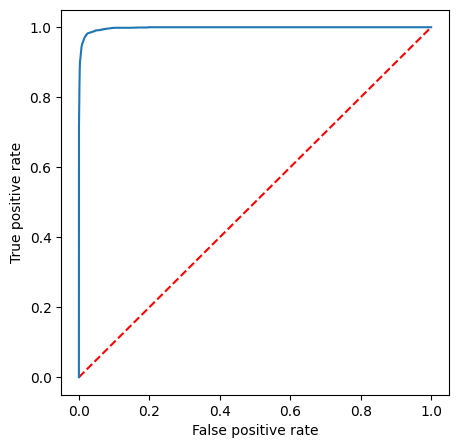

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
    lr_model.summary.roc.select("FPR").collect(),
    lr_model.summary.roc.select("TPR").collect(),
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

#### Optimizing hyperparameters with cross-validation

By fine-tuning some aspects of the model training (how Spark builds the fitted model), we can hope to yield better model accuracy. For this, we use a technique called cross-validation. Cross-validation resamples the data set into training and testing sets to assess the ability of the model to generalize over new data.

To build the set of hyperparameters we wish to evaluate our model against, we use the `ParamGridBuilder`, which assists in creating a Param Map.

For this, we start with the builder class. This builder class can take a series of `addGrid()` methods taking two parameters:
- The Param of the stage we want to modify. In this case, our LogisticRegression estimator was assigned to the variable lr, so lr.elasticNetParam is the Param in question.
- The values we wish to assign the hyperparameter on, passed as a list.

Once we are done, we call `build()`, and a list of Param Maps is returned.

In [27]:
from pyspark.ml.tuning import ParamGridBuilder

grid_search = (
    ParamGridBuilder()
    .addGrid(lr.elasticNetParam, [0.0, 1.0])
    .build()
)

print(grid_search)

[{Param(parent='LogisticRegression_a05d3680b6ec', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_a05d3680b6ec', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}]


Next, we need cross-validation. PySpark provides out-of-the-box K-fold cross-validation through the CrossValidator class. The CrossValidator object combines everything under a single abstraction. To build a cross-validator, we need three elements, all of which we’ve encountered so far:
- An estimator, which contains the model we wish to evaluate (here: `food_pipeline`)
- An estimatorParamMaps set, which is the list of Param Maps we created earlier in the section
- An evaluator, which carries the metric we wish to optimize against.

<img src="images/cross_validation.png">

In [28]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(
    estimator=food_pipeline,
    estimatorParamMaps=grid_search,
    evaluator=evaluator,
    numFolds=3,
    seed=13,
    collectSubModels=True,
)

cv_model = cv.fit(train)

print(cv_model.avgMetrics)

pipeline_food_model = cv_model.bestModel

[0.9892127611615564, 0.9892129800506251]


### Getting the biggest drivers from our model: Extracting the coefficients
This section covers the extraction of our model features and their coefficients. We use those coefficients to get a sense of the most important features of the model and plan some improvements for a second iteration.

In [29]:
import pandas as pd

feature_names = ["(Intercept)"] + [
    x["name"]
    for x in (
        food_features
        .schema["features"]
        .metadata["ml_attr"]["attrs"]["numeric"]
    )
]

feature_coefficients = [lr_model.intercept] + list(
                                                    lr_model.coefficients.values
                                                    )

coefficients = pd.DataFrame(
    feature_coefficients, index=feature_names, columns=["coef"]
)

coefficients["abs_coef"] = coefficients["coef"].abs()

print(coefficients.sort_values(["abs_coef"]))

                          coef   abs_coef
noodle               -0.008796   0.008796
picnic               -0.027102   0.027102
continuous_scaled_0   0.031784   0.031784
pie                   0.037988   0.037988
cinnamon             -0.048031   0.048031
...                        ...        ...
squid               -15.215416  15.215416
horseradish         -16.659087  16.659087
sangria             -18.324526  18.324526
plantain            -18.621401  18.621401
arugula             -19.459197  19.459197

[514 rows x 2 columns]


A coefficient close to zero, like kirsch, lemon, and food_processor, means that this feature is not very predictive of our model. On the flip side, a very high or low coefficient, like cauliflower, horseradish, and quick_and_healthy, means that this feature is highly predictive. When using a linear model, a positive coefficient means that the feature will predict toward a 1.0 (the dish is a dessert). Our results are not too surprising; looking at the very negative features, it seems that the presence of horseradish or a “quick and healthy” recipe means “not a dessert!”